# Predictive ElasticNet H5

Explore a hypothesis from `Predictive ElasticNet.ipynb`, this combines
- `Predictive ElasticNet H3.ipynb` which explored tuning ElasticNet parameters, and
- `Predictive ElasticNet H4.ipynb` which introduced a predictor sizing

See also `NonPredictive ElasticNet H5.ipynb` for a version using slightly different data

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp

In [2]:
# The range of years to gather data
YEARS = tuple(range(1878, 2020))
nyears = len(YEARS)

In [3]:
# Where to write figures to disk
FIG_DIR = 'Predictive ElasticNet H5 Figures'

## Data gathering

In [4]:
counts = pd.read_csv('data_ibm/data.csv', index_col=0).loc[YEARS[0]:YEARS[-1], 'counts']

In [5]:
# This data output by data_ibm/Generate data.ipynb
kozar1 = pd.read_csv('data_ibm/data.csv', index_col=0).loc[YEARS[0]:YEARS[-1], ['mdr_aso', 'nino34_djf', 'nao_djfm']]

# This data is output by data/Generate MDR.ipynb
# Using April values
kozar2p = pd.read_csv('data/data_mdr.csv', index_col=0).loc[YEARS[0]:YEARS[-1], ['4']]
kozar2p.columns = ['mdr_p']

Data used in the Kozar 2012 paper

In [6]:
kozar_np = kozar1.copy()
# Incorporate an intercept
kozar_np.insert(0, "icpt", np.ones((kozar_np.shape[0],)))

Predictive version of Kozar

In [7]:
kozar = pd.concat([kozar2p, kozar1.loc[:, ['nino34_djf', 'nao_djfm']]], axis=1)
# Incorporate an intercept
kozar.insert(0, "icpt", np.ones((kozar.shape[0],)))

We now have a few datasets:
- `counts` are the VK08 corrected counts
- `kozar_np` the "non-predictive" data used in Kozar 2012
- `kozar` is the "predictive" data using April MDR temperatures

## Define cross-validation periods

In [8]:
assert len(YEARS) == 142
cv_batch_idxs = [np.arange(2, 2+28), np.arange(2+28, 2+28*2), np.arange(2+28*2, 2+28*3), np.arange(2+28*3, 2+28*4), np.arange(2+28*4, 2+28*5)]
num_batches = len(cv_batch_idxs)

Prepare the datasets for cross validation.  First use the `cv_batch_idxs` to split into batches

In [9]:
def get_cv_data(batch_idx, data, cv_batch_idxs=cv_batch_idxs):
    """
    pass in data of shape (observation, feature)
    returns the i^th training and validation data sets
    """
    if isinstance(data, pd.DataFrame) or isinstance(data, pd.Series):
        data = data.values
    ndim = len(data.shape)
    assert ndim <= 3
    if ndim == 1: # one-dimensional
        batches = [data[idxs] for idxs in cv_batch_idxs]
    elif ndim == 2:
        batches = [data[idxs, :] for idxs in cv_batch_idxs]
    else:
        batches = [data[idxs, :, :] for idxs in cv_batch_idxs]
    train = np.concatenate([c for (i, c) in enumerate(batches) if i != batch_idx], axis=0).copy()
    valid = batches[batch_idx].copy()
    return train, valid    

# Test some models

## Intercept

In [10]:
def test_icpt():
    params = []
    errs = []
    preds = []
    for bidx in range(num_batches):
        counts_train, counts_valid = get_cv_data(bidx, counts)
        pred = np.mean(counts_train)
        err = np.mean(np.abs(counts_valid - pred))
        params.append(np.mean(counts_train))
        errs.append(err)
        preds.append(np.ones_like(counts_valid)*pred)
        print("{:d} {:f}".format(bidx, err))
    print()
    print("mean error = {:.4f}".format(np.mean(errs)))
    print("sdom error = {:.4f}".format(np.std(errs)/np.sqrt(len(errs))))
    return np.array(errs), params, np.concatenate(preds)
errs_icpt, params_icpt, preds_icpt = test_icpt()

0 2.648679
1 4.540209
2 2.228837
3 2.510242
4 5.243168

mean error = 3.4342
sdom error = 0.5448


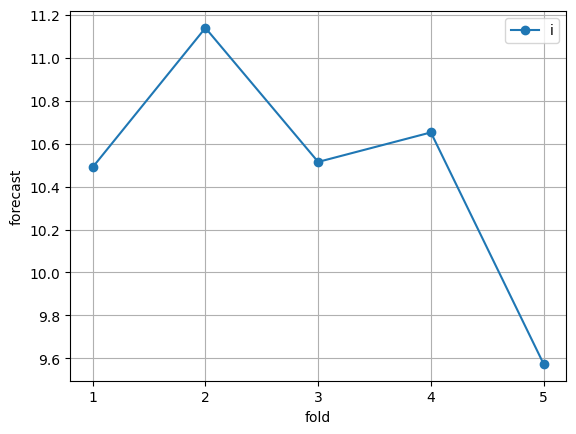

In [11]:
plt.plot(params_icpt, 'o-')
plt.xticks(range(5), range(1, 5+1))
plt.grid()
plt.legend(('intercept'))
plt.xlabel('fold')
plt.ylabel('forecast');

## Kozar 2012 (non-predictive)

In [12]:
def log_like(targets, forecast):
    return np.sum(targets * np.log(forecast) - forecast)


def calc_forecast(features, thetas):
    return np.exp(np.dot(features, thetas))


def make_objective(targets, features):
    # Log-Liklihood per observation has better gradient properties
    def foo(x):
        fc = calc_forecast(features, x)
        nobs = features.shape[0]
        return -log_like(targets, fc)/float(nobs)
    return foo


def clean(targets, features):
    # Return cleaned versions of targets and features
    good = np.logical_and(np.all(np.isfinite(features), axis=1), np.isfinite(targets))
    return targets[good], features[good, :]


def fit_poisson(targets, features):
    """
    Fit the model and deal with missing observations.  Note this scales up the 
    MSE.  Returns the betas.  Also return some additional information
    """
    # clean and fit
    t_, f_ = clean(targets, features)
    beta0 = np.zeros((f_.shape[1]))
    # solve
    res = sp.optimize.minimize(make_objective(t_, f_), beta0, method='L-BFGS-B')
    assert res.success
    return res.x

def fit_pr(targets_train, preds_train, pred_valid):
    """
    targets_train   (year,) counts
    pred_train  (year, pred) predictors
    """

    coefs = fit_poisson(targets_train, preds_train)
    # evalute the model on the validation set
    kozar_pred_valid = calc_forecast(pred_valid, coefs)
    return coefs, kozar_pred_valid

In [13]:
def test_kozar_np():
    errs = []
    params = []
    all_preds = []
    for bidx in range(num_batches):
        counts_train, counts_valid = get_cv_data(bidx, counts)
        kozar_train, kozar_valid = get_cv_data(bidx, kozar_np)
        # This step is important. We define mean temperatures using the training
        # data as a reference period, then using this mean in the validation period
        # This makes no difference in a Poisson regression: but makes it more 
        # interpretable and might matter in other fitting methods, so we do it here
        assert np.all(kozar_train[:, 0]==1)
        feat_means = np.mean(kozar_train[:, 1:], axis=0)
        # Demean training data
        train_dm = kozar_train.copy()
        train_dm[:, 1:] = kozar_train[:, 1:] - feat_means
        # Demean validation data
        valid_dm = kozar_valid.copy()
        valid_dm[:, 1:] = kozar_valid[:, 1:] - feat_means
        # Fit
        betas, preds = fit_pr(counts_train, train_dm, valid_dm)
        all_preds.append(preds)
        params.append(betas)
        err = np.mean(np.abs(preds - counts_valid))
        errs.append(err)
        print("{:d} {:f}".format(bidx, err))
    print()
    print("mean mae = {:.4f}".format(np.mean(errs)))
    print("sdom mae = {:.4f}".format(np.std(errs)/np.sqrt(len(errs))))
    return np.array(errs), params, np.concatenate(all_preds)
errs_kozar_np, params_kozar_np, preds_kozar_np = test_kozar_np()

0 2.271503
1 2.782778
2 2.376887
3 2.206847
4 2.671708

mean mae = 2.4619
sdom mae = 0.1011


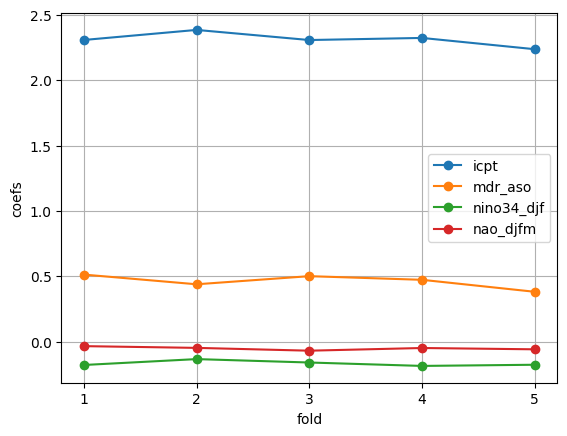

In [14]:
plt.plot(params_kozar_np, 'o-')
plt.xticks(range(5), range(1, 5+1))
plt.grid()
plt.legend(kozar_np.columns)
plt.xlabel('fold')
plt.ylabel('coefs');

## Predictive Kozar

In [15]:
def test_kozar():
    errs = []
    params = []
    all_preds = []
    for bidx in range(num_batches):
        counts_train, counts_valid = get_cv_data(bidx, counts)
        kozar_train, kozar_valid = get_cv_data(bidx, kozar)
        # This step is important. We define mean temperatures using the training
        # data as a reference period, then using this mean in the validation period
        # This makes no difference in a Poisson regression: but makes it more 
        # interpretable and might matter in other fitting methods, so we do it here
        assert np.all(kozar_train[:, 0]==1)
        feat_means = np.mean(kozar_train[:, 1:], axis=0)
        # Demean training data
        train_dm = kozar_train.copy()
        train_dm[:, 1:] = kozar_train[:, 1:] - feat_means
        # Demean validation data
        valid_dm = kozar_valid.copy()
        valid_dm[:, 1:] = kozar_valid[:, 1:] - feat_means
        # Fit
        betas, preds = fit_pr(counts_train, train_dm, valid_dm)
        all_preds.append(preds)
        params.append(betas)
        err = np.mean(np.abs(preds - counts_valid))
        errs.append(err)
        print("{:d} {:f}".format(bidx, err))
    print()
    print("mean mae = {:.4f}".format(np.mean(errs)))
    print("sdom mae = {:.4f}".format(np.std(errs)/np.sqrt(len(errs))))
    return np.array(errs), params, np.concatenate(all_preds)
errs_kozar, params_kozar, preds_kozar = test_kozar();

0 2.138035
1 3.186381
2 2.378595
3 2.718120
4 3.614084

mean mae = 2.8070
sdom mae = 0.2395


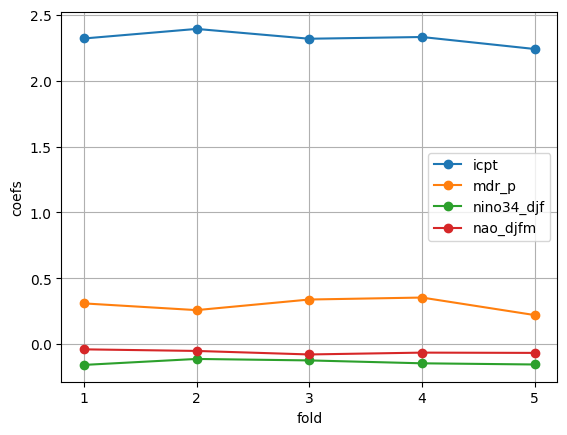

In [16]:
plt.plot(params_kozar, 'o-')
plt.xticks(range(5), range(1, 5+1))
plt.grid()
plt.legend(kozar.columns)
plt.xlabel('fold')
plt.ylabel('coefs');

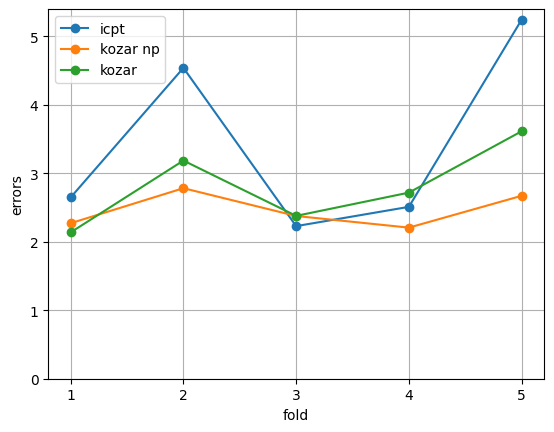

In [17]:
plt.plot(errs_icpt, 'o-')
plt.plot(errs_kozar_np, 'o-')
plt.plot(errs_kozar, 'o-')
plt.xticks(range(5), range(1, 5+1))
plt.xlabel('fold')
plt.ylabel('errors')
plt.grid()
plt.ylim(0, max(plt.ylim()))
plt.legend(('icpt', 'kozar np', 'kozar'))

## ElasticNet

See `SST ElasticNet vs Baseline.ipynb` for details. I"m just copying code from there.

In [18]:
import netCDF4 as nc

In [19]:
# The path to the directory storing the ERSSTv5 data files
DATA_DIR = "../ERSSTv5"

In [20]:
year_data = []
for yidx, year in enumerate(YEARS):
    mo_data = []
    for midx, month in enumerate(range(1, 12+1)):
        x = nc.Dataset(os.path.join(DATA_DIR, "ersst.v5.{:4d}{:02d}.nc".format(year, month)))['sst'][0, 0, :, :].filled(np.nan)
        mo_data.append(x)
    year_data.append(np.stack(mo_data, axis=0))
raw_sst = np.stack(year_data, axis=0) # shape (year, month, lat, lon)
nlat, nlon = x.shape

In [21]:
land_mask = np.any(np.all(np.isnan(raw_sst), axis=0), axis=0)
sea_mask = np.logical_not(land_mask)

In [22]:
good_std = np.all(np.std(raw_sst, axis=0) > 0.1, axis=0)

In [23]:
mask = np.logical_and(good_std, sea_mask)

Define a `(year, month, pixel)` array called `sst` that only includes good ocean points

In [24]:
curr_sst = raw_sst[:, :, mask]

Previous year SST

In [25]:
prev_sst = np.zeros_like(curr_sst)
prev_sst[1:, :, :] = curr_sst[:-1, :, :]

Now unlike the previous notebook, to be "predictive" we only want information through April of this year.  For an apples-to-apples comparison with the Kozar predictors, let's include December of the prior year

In [26]:
prev_sst[:, -1:, :].shape

(142, 1, 8758)

In [27]:
curr_sst[:, :4, :].shape

(142, 4, 8758)

In [28]:
sst = np.concatenate([prev_sst[:, -1:, :], curr_sst[:, :4, :]], axis=1)

## ElasticNet fitting code

In [29]:
def pred(features, betas):
    return np.exp(np.dot(features, betas))

def grad(targets, features, betas, lamb1, lamb2, nopenalty=None, return_obj=False):
    """
    Compute the gradient of the Poisson regression log-likelihood with ElasticNet penalty terms
    
    targets (n,) 
    features (n, m)
    betas (m,)
    lamb1  Lasso penalty
    lamb2  ridge penalty
    nopenalty  index or list of indices of predictors which we don't want to penalize
    """
    # number of observations
    nobs = len(targets)
    # forecast with these betas
    yhat = pred(features, betas)
    # Gradient of log-likelihood
    grad_ll = np.dot(targets, features) - (features * yhat.reshape((-1,1))).sum(axis=0)
    # Gradient of lasso penalty
    grad_L1 = np.sign(betas)
    # gradient of ridge penalty
    grad_L2 = betas.copy()
    # Zero out penalties for some features
    if nopenalty is not None:
        grad_L1[nopenalty] = 0
        grad_L2[nopenalty] = 0
    gradient = grad_ll/float(nobs) - lamb1 * grad_L1 - lamb2 * grad_L2
    # Compute log likelihood if desired
    if return_obj:
        obj = sum(np.dot(np.log(yhat), targets) - yhat)
        return gradient, obj
    return gradient

def _init_betas(beta0, nfeat):
    if beta0 is None:
        return np.zeros((nfeat,))
    return beta0.copy()


def _grad_ascent(targets, features, lamb1, lamb2,
                 alpha=1e-4,
                 nopenalty=None, 
                 beta0=None,
                 max_steps=10000,
                 buffer=100,
                 return_objs=False):
    """
    Assume NumPy array inputs
    
    targets: (n,)
    features: (n, m)
    alpha: learning rate dx = alpha * grad
    lamb1, lamb2: elasticnet params
    nopenalty: which features to not penalize
    beta0: starting value of betas
    buffer: how long to wait without improving max_obj
    """
    nobs, nfeat = features.shape
    # initialize betas
    betas = _init_betas(beta0, nfeat)
    # record values of the objective function
    objs = []
    max_obj, max_betas, max_tt = -np.inf, None, None
    success = False
    for tt in range(max_steps):
        # compute gradient and objective
        gradient, obj = grad(targets, features, betas, lamb1, lamb2, nopenalty=nopenalty, return_obj=True)
        objs.append(obj)
        # update max objective if needed
        if obj > max_obj:
            max_obj, max_betas, max_tt = obj, betas, tt
        # if we haven't improved the objective, let's terminate early
        if tt > max_tt + buffer:
            success = True
            break
        # ascend the hill
        betas = betas + alpha * gradient
    return max_betas, success, {'max_obj':max_obj, 'obj':obj, 'max_tt':max_tt, 'tt':tt, 'objs':np.array(objs)}


def fit_en(targets_train, sst_train, sst_valid, 
           lamb1=0.03, lamb2=0.03, alpha=1e-6, max_steps=20000, 
           std_thresh=0.1, zsst_clip_quantile=0.01, two_stage_fit=True,
           debug=False):
    """
    targets_train   (year,) counts
    sst_train  (year, month, pixel) SST data for training 
    """

    # Normalize the sst data
    # Compute (month, pixel) means and std
    sst_mean = np.mean(sst_train, axis=0) # (month, pixel)
    sst_std = np.std(sst_train, axis=0) # (month, pixel)

    zsst_train = (sst_train - sst_mean)/sst_std
    # some std are quite small which causes issues - unrealistically low temperature variation
    # these seem to be pixels 
    zsst_train[:, sst_std < std_thresh] = 0
    #zsst_train = np.clip(zsst_train, -3, 3) # clip for consistency with validation
    #zclip = np.quantile(zsst_train, [zsst_clip_quantile, 1-zsst_clip_quantile])
    #zsst_train = np.clip(zsst_train, *zclip)
    
    # Add an intercept as the last feature
    nyears_train = zsst_train.shape[0]
    features_train = np.concatenate([zsst_train.copy().reshape((nyears_train, -1)), np.ones((nyears_train, 1))], axis=-1)
    icpt_idx = features_train.shape[1] - 1

    # Do the fit on training data
    beta0 = np.zeros((features_train.shape[1],))
    beta0[-1] = np.log(np.mean(targets_train)) # initialize intercept
    betas, success, stats = _grad_ascent(targets_train, features_train, lamb1, lamb2, beta0=beta0, nopenalty=icpt_idx, 
                                         alpha=alpha, max_steps=max_steps)
    assert success, "Failed optimization"    

    # This is the new part.  We do a Poisson regression to change the scale
    # of the features.  ElasticNet will tend to shrink model parameters (betas)
    # to zero, this may help undo this.
    if two_stage_fit:
        agg = np.dot(features_train[:, :-1], betas[:-1])
        X = np.vstack([agg, np.ones((nyears_train,)) * betas[-1]]).T
        beta2 = fit_poisson(targets_train, X)
        betas[:-1] = betas[:-1] * beta2[0] # composite predictor scaling
        betas[-1] = betas[-1] * beta2[1] # intercept scaling
    else:
        beta2 = None
    
    # Forecast on validation data
    # Normalize the validation data
    zsst_valid = (sst_valid - sst_mean)/sst_std
    zsst_valid[:, sst_std < std_thresh] = 0 # unrealistically low temperature variation over the years
    #zsst_valid = np.clip(zsst_valid, -3, 3) # clip large excursions - probably a bug
    #zsst_valid = np.clip(zsst_valid, *zclip)

    # Add the intercept
    nyears_valid = zsst_valid.shape[0]
    features_valid = np.concatenate([zsst_valid.copy().reshape((nyears_valid, -1)), np.ones((nyears_valid, 1))], axis=-1)
    pred_valid = pred(features_valid, betas)

    return {'betas':betas, 'beta2':beta2}, pred_valid

In [32]:
def test_en(lamb1, lamb2):
    errs = []
    params = []
    all_preds = []
    print("   mae    scales")
    for bidx in range(num_batches):
        counts_train, counts_valid = get_cv_data(bidx, counts)
        sst_train, sst_valid = get_cv_data(bidx, sst)
        betas, preds = fit_en(counts_train, sst_train, sst_valid, lamb1=lamb1, lamb2=lamb2)
        all_preds.append(preds)
        params.append(betas)
        err = np.mean(np.abs(preds - counts_valid))
        errs.append(err)
        print("{:d} {:6.4f} {:6.4f} {:6.4f}".format(bidx, err, betas['beta2'][0], betas['beta2'][1]))
    print()
    print("mean mae    {:.4f}".format(np.mean(errs)))
    print("sdom mae    {:.4f}".format(np.std(errs)/np.sqrt(len(errs))))
    print("mean fudge0 {:.4f}".format(np.mean([p['beta2'][0] for p in params])))
    print("mean fudge1 {:.4f}".format(np.mean([p['beta2'][1] for p in params])))
    return np.array(errs), params, np.concatenate(all_preds)
#errs_en, params_en, preds_en = test_en(0, 0);

In [74]:
lat_values = np.arange(-88, 88+1, 2, dtype=int)
lon_values = np.arange(0, 358+1, 2, dtype=int)
nlat = len(lat_values)
nlon = len(lon_values)

def plot_betas(betas, savefigname=None):
    """
    pass in all betas to generate a plot
    """
    monthnames = [None, 'prior year December', 'January', 'February', 'March', 'April']
    q1, q2 = np.quantile(betas[:-1], [.01, .99])
    q2 = max(abs(q1), abs(q2))
    q1 = -q2
    print("lower / upper range = " + str((q1, q2)))
    fig, axs = plt.subplots(3, 2, figsize=(12,10), tight_layout=True)
    last_plot = None
    for row in range(3):
        for col in range(2):
            month = 1 + col + 2*row
            if month > 5:
                fig.delaxes(axs[row, col])
                continue
            map = np.ones((nlat, nlon)) * np.nan
            map[mask] = betas[:-1].reshape((5, -1))[month-1, :]
            last_plot = axs[row, col].imshow(map[::-1, :], cmap='rainbow', vmin=q1, vmax=q2)
            axs[row, col].set_title('Betas Month {:d}'.format(month), fontsize=10)
            axs[row, col].set_title('Betas for ' + monthnames[month], fontsize=10)
            axs[row, col].set_xticks(range(0, nlon, 30), np.array(lon_values[::30], dtype='int'), fontsize=10)
            axs[row, col].set_yticks(range(4, nlat, 10), np.array(lat_values[::-1][4::10], dtype='int'), fontsize=10)
            if row == 2 and col == 0:
                axs[row, col].set_xlabel('latitude', fontsize=10)
                axs[row, col].set_ylabel('longitude', fontsize=10)
    cb_ax = fig.add_axes([.54,.06,.02,.263])
    cb = fig.colorbar(last_plot, cax=cb_ax)
    cb.formatter.set_powerlimits((0, 0))


    if savefigname is not None:
        plt.savefig(os.path.join(FIG_DIR, savefigname))

def plot_sst(sst):
    """
    pass in (month, pixel) sst data to generate plots
    """
    q1, q2 = np.quantile(sst, [.01, .99])
    print("lower / upper range = " + str((q1, q2)))
    fig, axs = plt.subplots(3, 2, figsize=(12,12), sharex=True, sharey=True)
    for row in range(3):
        for col in range(2):
            month = 1 + col + 2*row
            map = np.ones((nlat, nlon)) * np.nan
            map[mask] = sst[month-1, :]
            axs[row, col].imshow(map[::-1, :], cmap='rainbow', vmin=q1, vmax=q2)
            axs[row, col].set_title('SST Month {:d}'.format(month-6), fontsize=10)

In [ ]:
bidx = 4
plot_betas(params_en[bidx]['betas'])

Preliminary scan, along pure Lasso or Ridge axes

In [ ]:
lambs = [(1e-3, 0),
         (1e-2, 0),
         (1e-1, 0),
         (1,    0),
         (0,    1),
         (0,    10),
         (0,    1e2),
         (0,    1e3),
         (0,    1e4)]

In [ ]:
outs = []
for ii, (lamb1, lamb2) in enumerate(lambs):
    print(ii, lamb1, lamb2)
    o = test_en(lamb1, lamb2)
    outs.append(o)

I am already seeing some good results!

**Predictive Kozar model**

From `Predictive ElasticNet.iypnb`
```
0 2.138035
1 3.186381
2 2.378595
3 2.718120
4 3.614084

mean mae = 2.8070
sdom mae = 0.2395
```

**Pure Lasso regularization**
```
1 0
   mae    fudge
0 2.8619 1.8394 0.9821
1 3.1638 2.3235 0.9898
2 2.5849 1.8419 0.9813
3 2.5634 1.8497 0.9828
4 2.9371 4.2934 0.9919

mean mae    2.8222
sdom mae    0.1010
mean fudge0 2.4296
mean fudge1 0.9856
```

**Pure ridge regularization**
```
0 10000.0
   mae    fudge
0 3.1153 1.4326 0.9793
1 3.2900 1.6068 0.9865
2 2.4573 1.4820 0.9785
3 2.3256 1.4627 0.9809
4 3.1065 2.4304 0.9820

mean mae    2.8589
sdom mae    0.1742
mean fudge0 1.6829
mean fudge1 0.9815
```

Let's look at the betas

In [ ]:
lambs[3]

In [ ]:
plot_betas(outs[3][1][3]['betas'])

In [ ]:
lambs[8]

In [ ]:
plot_betas(outs[8][1][3]['betas'])

Grid scan

In [34]:
lamb2s = [(l1, l2) for l1 in [.1, 1, 10] for l2 in [1e3, 1e4, 1e5]]

In [ ]:
out2s = []
for ii, (lamb1, lamb2) in enumerate(lamb2s):
    print(ii, lamb1, lamb2)
    o = test_en(lamb1, lamb2)
    out2s.append(o)

In [ ]:
#plot_betas(out2s[4][1][3]['betas'], savefigname="betas_pred_illustrate.png")

In [35]:
# quick figure generation

In [37]:
o = test_en(*lamb2s[4])

   mae    scales
0 2.8442 2.8219 0.9844
1 3.2033 4.7757 0.9914
2 2.4565 2.7831 0.9843
3 2.5486 2.8433 0.9861
4 2.8509 22.0652 0.9922

mean mae    2.7807
sdom mae    0.1177
mean fudge0 7.0578
mean fudge1 0.9877


lower / upper range = (-0.00011827707387348741, 0.00011827707387348741)


/var/folders/50/j5b90yx53cd6b3kt1ytt_dy40000gn/T/ipykernel_73214/10534455.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(FIG_DIR, savefigname))
/Users/wes/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


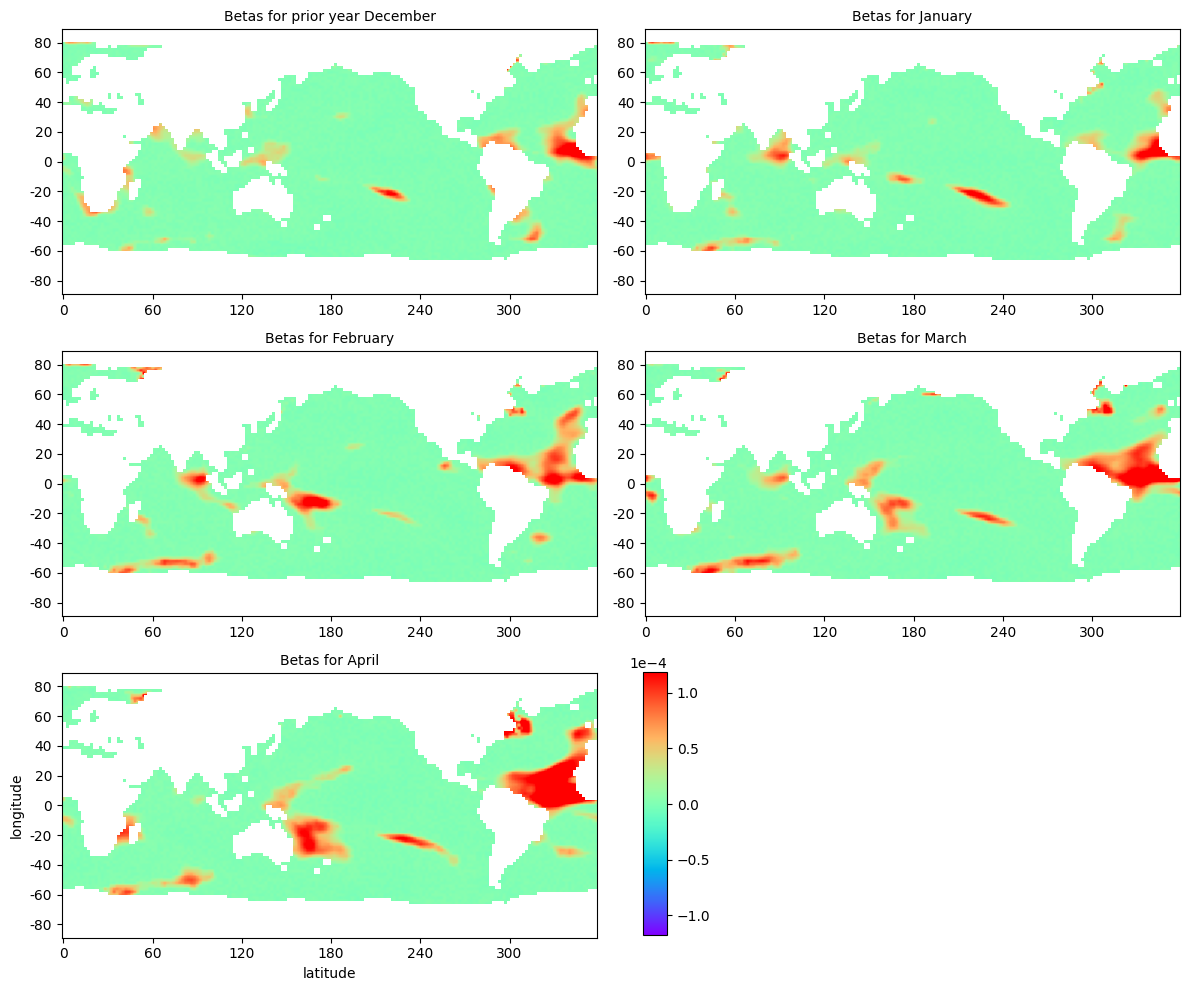

In [75]:
plot_betas(o[1][3]['betas'], savefigname="betas_pred_illustrate.png")

In [ ]:
b = out2s[4][1][3]['betas'][:-1]

In [ ]:
plt.plot(sorted(np.abs(b)))
plt.grid()

In [ ]:
all_cv_counts = np.concatenate([get_cv_data(b, counts)[1] for b in range(5)])
plt.plot(all_cv_counts)
plt.plot(out2s[4][2])
plt.plot(preds_kozar)
plt.legend(('counts', 'EN', 'kozar'))

In [ ]:
plt.scatter(preds_kozar, out2s[4][2])
plt.title('prediction scatterplot')
plt.xlabel('kozar')
plt.ylabel('elasticnet')
print(np.corrcoef(preds_kozar, out2s[4][2]))

In [ ]:
plt.scatter(preds_kozar - all_cv_counts, out2s[4][2] - all_cv_counts)
plt.title('residuals scatterplot')
plt.xlabel('kozar')
plt.ylabel('elasticnet')
print(np.corrcoef(preds_kozar - all_cv_counts, out2s[4][2] - all_cv_counts))

### Can I tune further?

In [ ]:
lamb3s = [(l1, l2) for l1 in np.geomspace(1/3., 3., 5) for l2 in np.geomspace(1e4/3., 3e4, 5)]

In [ ]:
out3s = []
min_err = np.inf
min_err_idx = None
for ii, (lamb1, lamb2) in enumerate(lamb3s):
    print()
    print(ii, lamb1, lamb2)
    o = test_en(lamb1, lamb2)
    err = np.mean(o[0])
    if err < min_err:
        print("new minimum error")
        min_err = err
        min_err_idx = ii
    out3s.append(o)

print("\n\nMinimum error {:f} @ index {:d}".format(min_err, min_err_idx))

In [ ]:
def comparison_table(*models):
    """
    Given a list of error series compute various observables and produce a LaTeX table.
    Arguments are a list of tuples with error timeseries
    comparison_table((name1, errs1), (name2, errs2), ...)
    """
    nfolds = None
    base_errs = None
    for ii, (name, errs) in enumerate(models):
        if nfolds is None:
            nfolds = len(errs)
        else:
            assert nfolds == len(errs), "different number of folds"
        srn = np.sqrt(nfolds)
        mean = np.mean(errs)
        sdom = np.std(errs)/srn
        s = "{:20s} & {:4.2f} & {:4.2f} ".format(name, mean, sdom)
        if ii == 0:
            base_errs = errs
            s += "&       &       &      \\\ "
        else:
            derrs = errs - base_errs
            mean_d = np.mean(derrs)
            sdom_d = np.std(derrs)/srn
            s += "& {:4.2f} & {:5.2f} & {:5.2f} \\\ ".format(mean_d, sdom_d, mean_d/sdom_d)
        print(s)

In [ ]:
comparison_table(("baseline predictive", errs_kozar),
                 ("EN $(1, 10^4)$",      out2s[4][0]),
                 ("EN minimum",          out3s[5][0]))